In [ ]:
import tensorflow as tf
import keras.applications.resnet50
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [ ]:
!pip install tensorflow-addons

Encoder part using ResNET

In [ ]:
from tensorflow import Tensor 
from tensorflow.keras.layers import Input, Conv3D, ReLU, Add, AveragePooling3D, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

from tensorflow_addons.layers import GroupNormalization

In [ ]:
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

#Function for 2D Residual Block

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
  
    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def residual_block_decode(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = layers.Conv2DTranspose(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = layers.Conv2DTranspose(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
  
    if downsample:
        x = layers.Conv2DTranspose(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
#Function for 3D Residual Block

def relu_bn3d(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = GroupNormalization()(relu)
    return bn

def residual_block3d(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv3D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn3d(y)
    y = Conv3D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
  
    if downsample:
        x = Conv3D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn3d(out)
    return out

In [ ]:
# Function to create Encoder model

def create_resnet_encoder():
    
    inputs = Input(shape=(256, 256, 3))
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=64,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 2, 3, 3]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=64)
    
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=128,
               padding="same")(t)
    t = layers.Reshape((32, 32, 64, 2))(t)
    t = layers.Conv3D(64, (3, 3, 3), padding='same', strides=(1, 1,  1))(t)

    num_blocks_list = [2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block3d(t, downsample=(j==0 and i!=0), filters=64)

    outputs = t 
  
    return (inputs,outputs)

In [ ]:
model1 = create_resnet_encoder()

In [ ]:
def warp():
  pass

Decoder part

In [ ]:
# Function to create Dencoder model

def create_resnet_dencoder():
    inputen, outputen = create_resnet_encoder()
    # inputs = Input(shape=(32, 32, 64, 64))(outputen)

    t = outputen
    num_blocks_list = [2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block3d(t, downsample=0, filters=64)
    
    t = layers.Conv3D(10, (3, 3, 3), padding='same', strides=(1, 1,  1))(t)
    t = layers.Conv3D(2, (3, 3, 3), padding='same', strides=(1, 1,  1))(t)
    t = layers.Reshape((32, 32, 128))(t)
    t = layers.Conv2DTranspose(64,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            use_bias=False)(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=0, filters=64)
        t = layers.Conv2DTranspose(64,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            use_bias=False)(t)
        # t = layers.UpSampling2D(size=2)(t)
    
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=128,
               padding="same")(t)
    t = relu_bn(t)

    t = layers.Conv2D(filters=64, kernel_size=3, padding='same')(t)
    t = layers.Conv2D(filters=32, kernel_size=3, padding='same')(t)
    t = layers.Conv2D(filters=16, kernel_size=3, padding='same')(t)
    t = layers.Conv2D(filters=3, kernel_size=3, padding='same')(t)
    outputs = t 
  
    model = Model(inputen, outputs)

    return model

In [ ]:
model = create_resnet_dencoder()

In [ ]:
tf.keras.utils.plot_model(model, "decoder.png", show_shapes=True)

In [ ]:
model.summary()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

# from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

In [ ]:
def downsample(filters, apply_norm=True):
  result = keras.Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # Convolutional layer
  result.add(layers.Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_norm)) # when applying Normalization you already have the bias implicit

  # Normalization layer
  if apply_norm:
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)) 

  # Activation layer
  result.add(layers.LeakyReLU())

  return result


In [ ]:
def Discriminator():
  
  ini = layers.Input(shape=[256, 256, 3], name="input_img")
    
  # t = GroupNormalization()(ini)
  t = Conv2D(kernel_size=3,
               strides=1,
               filters=64,
               padding="same")(ini)
  t = relu_bn(t)
    
  num_blocks_list = [2,5, 5,2]
  for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=64)
    
    
  output3 = t

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(output3) # (bs, 34, 34, 256)

  initializer = tf.random_normal_initializer(0., 0.02)
  conv = tf.keras.layers.Conv2D(512, 
                                kernel_size=4, 
                                strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 
                                kernel_size=4, 
                                strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return keras.Model(inputs=ini, outputs=last)

In [ ]:
generator_g = create_resnet_dencoder()

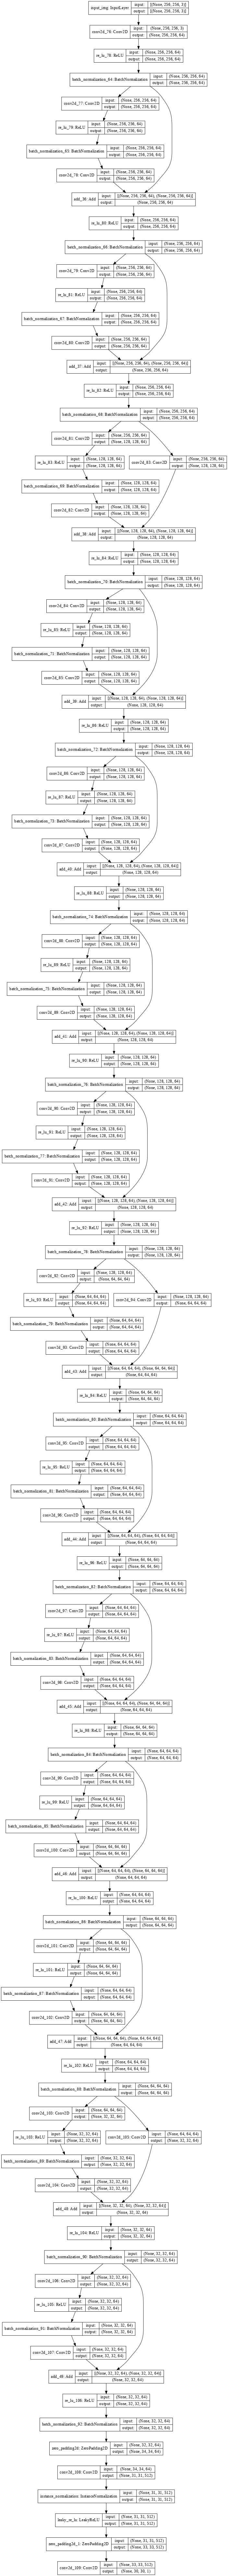

In [ ]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

Dataset using tf.data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab-Notebooks/img.zip /content/
!unzip /content/img.zip -d /content/

In [ ]:
# import the necessary packages
from tensorflow.data import AUTOTUNE
from imutils import paths
import tensorflow as tf
import numpy as np
import time
import os

In [ ]:
def load_images(imagePath):
	# read the image from disk, decode it, resize it, and scale the
	# pixels intensities to the range [0, 1]
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.resize(image, (256, 256)) / 255.0

	# grab the label and encode it
	label = tf.strings.split(imagePath, os.path.sep)[1]
	oneHot = label == classNames
	encodedLabel = tf.argmax(oneHot)

	# return the image and the integer encoded label
	return (image, encodedLabel)

In [ ]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "dataset": "img"
}

In [ ]:
# grab the list of images in our dataset directory and grab all
# unique class names
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(args["dataset"]))
classNames = np.array(sorted(os.listdir(args["dataset"])))

[INFO] loading image paths...


In [ ]:
folders = os.listdir(args["dataset"])
classNames = np.array([])
for gender in folders:
  subfol = os.listdir('img/' + gender)
  # classNames = np.append(classNames, 
  for dress in subfol:
    classNames = np.append(classNames,tf.strings.join([gender,dress], separator='-'))
  # print(subfol)

In [ ]:
print(classNames)

[b'WOMEN-Pants' b'WOMEN-Cardigans' b'WOMEN-Blouses_Shirts' b'WOMEN-Denim'
 b'WOMEN-Graphic_Tees' b'WOMEN-Sweatshirts_Hoodies' b'WOMEN-Skirts'
 b'WOMEN-Dresses' b'WOMEN-Sweaters' b'WOMEN-Rompers_Jumpsuits'
 b'WOMEN-Tees_Tanks' b'WOMEN-Shorts' b'WOMEN-Jackets_Coats'
 b'WOMEN-Leggings' b'MEN-Pants' b'MEN-Jackets_Vests' b'MEN-Denim'
 b'MEN-Sweatshirts_Hoodies' b'MEN-Sweaters' b'MEN-Tees_Tanks'
 b'MEN-Shirts_Polos' b'MEN-Shorts' b'MEN-Suiting']


In [ ]:
info = tf.strings.split(imagePaths[0], os.path.sep)

# view=""
# for ch in info[-1]:
#   if((ch<'z' and ch>'a') or (ch<'Z' and ch>'a')):
#     view+= ch
gender = info[1]
dress = info[2]
label = tf.strings.join([gender,dress], separator='-')
print(label)

tf.Tensor(b'WOMEN-Pants', shape=(), dtype=string)


In [ ]:
# initialize batch size and number of steps
BS = 88
NUM_STEPS = 599

In [ ]:
# build the dataset and data input pipeline
print("[INFO] creating a tf.data input pipeline..")
dataset = tf.data.Dataset.from_tensor_slices(imagePaths)

options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.autotune_ram_budget= True
options.experimental_optimization.apply_default_optimizations = False
dataset = dataset.with_options(options)

dataset = (dataset
    .shuffle(52712)
    .cache()  # Cache data
    .map(  # Reduce memory usage
        load_images,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BS)
    .prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )
)

[INFO] creating a tf.data input pipeline..


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def benchmark(datasetGen, numSteps):
  # start our timer
  start = time.time()

  # loop over the provided number of steps
  for i in range(0, numSteps):
    # get the next batch of data (we don't do anything with the
    # data since we are just benchmarking)
    (images,labels) = next(datasetGen)
    for image in images:
      plt.imshow(image)
      plt.show()

  # stop the timer
  end = time.time()

  # return the difference between end and start times
  return (end - start)


In [ ]:
# create a dataset iterator, benchmark the tf.data pipeline, and
# display the number of data points generated, along with the time
# taken
datasetGen = iter(dataset)
totalTime = benchmark(datasetGen, NUM_STEPS)
print("[INFO] tf.data generated {} images in {:.2f} seconds...".format(
	BS * NUM_STEPS, totalTime))

In [ ]:
datasetGen = iter(dataset)

In [ ]:
sample_images,sample_labels = next(iter(dataset))

In [ ]:
def denormalize(image):
  image = tf.cast(image, tf.float32)
  image = (image * 0.5 + 0.5) * 255 # Range 0 to 1 and then to range 0..255
  image = tf.cast(image, tf.int32)
  return image

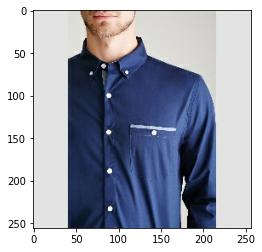

In [ ]:
photo = sample_images[25]
plt.imshow(photo)

In [ ]:
example_gen_output_y = generator_g(photo[tf.newaxis,...], training=False)
example_disc_out = discriminator_y(photo[tf.newaxis,...], training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 30, 30, 1)


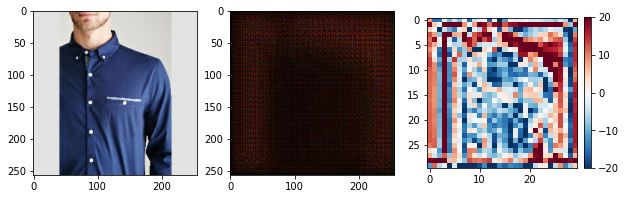

In [ ]:
print(example_disc_out.shape)

plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(photo, vmin=0, vmax=255) 

plt.subplot(1,3,2)
plt.imshow(example_gen_output_y[0,...]) 

plt.subplot(1,3,3)
m = example_disc_out[0,...,-1].numpy()*1000
im = plt.imshow(m, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.show()

Train GAN

In [ ]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)


In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  #compare the real image with a matrix of 1. (All Ok)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #compare the fake image with a matrix of 0 (All Fake)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)  

  total_disc_loss = (real_loss + generated_loss) / 2

  return total_disc_loss

In [ ]:
def generator_adversarial_loss(generated):
      return loss_object(tf.ones_like(generated), generated)

In [ ]:
def generator_calc_cycle_loss(real_image, cycled_image, param_lambda):
      loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

      return param_lambda * loss1

In [ ]:
def generator_identity_loss(real_image, same_image, param_lambda):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return param_lambda * 0.5 * loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)